In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
from sklearn.metrics import r2_score

import scipy.stats as st

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


> retrieve data

In [2]:
data = pd.read_csv('sales.csv', index_col=0)
data.head(50)

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
425390,366,4,2013-04-18,517,1,0,0,0,4422
291687,394,6,2015-04-11,694,1,0,0,0,8297
411278,807,4,2013-08-29,970,1,1,0,0,9729
664714,802,2,2013-05-28,473,1,1,0,0,6513
540835,726,4,2013-10-10,1068,1,1,0,0,10882
687329,674,2,2013-03-19,1016,1,1,0,0,8406
600327,659,7,2014-06-08,0,0,0,0,0,0
96265,27,3,2014-07-16,1106,1,1,0,1,11162
364435,347,6,2013-05-11,448,1,0,0,0,5559
163146,288,2,2013-06-25,291,1,0,0,0,3997


In [3]:
data.isna().sum()

store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64

> sanity checks to make sure the data is correct

In [4]:
display(data['store_ID'].value_counts())

store_ID
1045    645
309     636
754     635
432     634
286     634
       ... 
1004    448
287     448
1065    445
81      438
542     436
Name: count, Length: 1115, dtype: int64

In [5]:
#should be one through 7
display(data['day_of_week'].value_counts())

day_of_week
5    92138
4    91972
2    91686
3    91651
6    91347
7    91075
1    90971
Name: count, dtype: int64

In [6]:
display(data['open'].value_counts())

open
1    532016
0    108824
Name: count, dtype: int64

In [7]:
display(data['promotion'].value_counts())

promotion
0    396220
1    244620
Name: count, dtype: int64

In [8]:
display(data['state_holiday'].value_counts())
# --> turn into 0 or 1, a,b,c is state data--

state_holiday
0    621160
a     12842
b      4214
c      2624
Name: count, dtype: int64

In [9]:
multiple_holidays_count = 0
holiday_by_store = data.groupby('store_ID')['state_holiday'].unique()
# Check if any store_ID has more than one type of state holiday ('a', 'b', 'c')
for store_id, holidays in holiday_by_store.items():
    if len(set(holidays) - {'0'}) > 1: 
        multiple_holidays_count += 1
print(f"Number of store_IDs with multiple state holidays: {multiple_holidays_count}")

Number of store_IDs with multiple state holidays: 1115


In [10]:
data['state_holiday'] = data['state_holiday'].map({'0': 0,'a': 1, 'b': 1, 'c': 1})
display(data['state_holiday'].value_counts())

state_holiday
0    621160
1     19680
Name: count, dtype: int64

In [11]:
# check for invalid sales
data[
    (data['nb_customers_on_day'] == 0) &
    (data['sales'] != 0) &
    ((data['open'] != 0) | (data['promotion'] != 0) | (data['state_holiday'] != 0) | (data['school_holiday'] != 0))
]

,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales


In [12]:
display(data['school_holiday'].value_counts())

school_holiday
0    526468
1    114372
Name: count, dtype: int64

> date  
-- extr


In [13]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [14]:
display(data['year'].value_counts())

year
2013    256337
2014    235602
2015    148901
Name: count, dtype: int64

In [15]:
display(data['month'].value_counts())

month
5     65529
3     65399
1     65325
6     63370
4     63030
7     61714
2     58989
12    40066
10    40037
8     39910
11    38771
9     38700
Name: count, dtype: int64

In [16]:
data.drop(['date'], axis=1, inplace=True)

In [17]:
data

,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,year,month,day
425390,366,4,517,1,0,0,0,4422,2013,4,18
291687,394,6,694,1,0,0,0,8297,2015,4,11
411278,807,4,970,1,1,0,0,9729,2013,8,29
664714,802,2,473,1,1,0,0,6513,2013,5,28
540835,726,4,1068,1,1,0,0,10882,2013,10,10
...,...,...,...,...,...,...,...,...,...,...,...
359783,409,6,483,1,0,0,0,4553,2013,10,26
152315,97,1,987,1,1,0,0,12307,2014,4,14
117952,987,1,925,1,0,0,0,6800,2014,7,7
435829,1084,4,725,1,0,0,0,5344,2014,6,12


> visualize 

In [18]:
# sns.barplot(data=data, x='year', y='sales', estimator='sum')
# plt.show()

In [19]:
# sns.barplot(data=data, x='month', y='sales', estimator='sum')
# plt.show()

In [20]:
# sns.barplot(data=data, x='day', y='sales', estimator='sum')
# plt.show()

In [21]:
# sns.barplot(data=data, x='day_of_week', y='sales')
# plt.show()

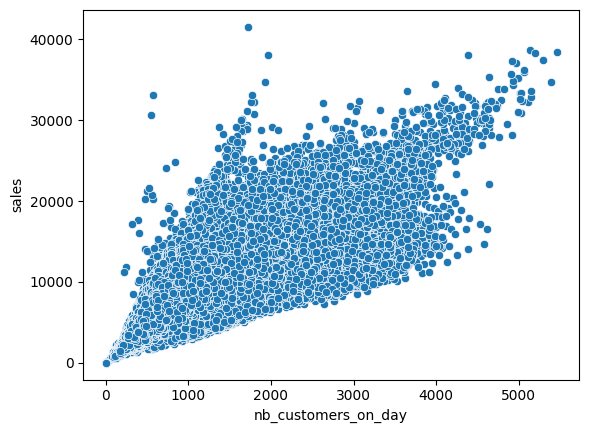

In [22]:
sns.scatterplot(data=data, x='nb_customers_on_day', y='sales')
plt.show()

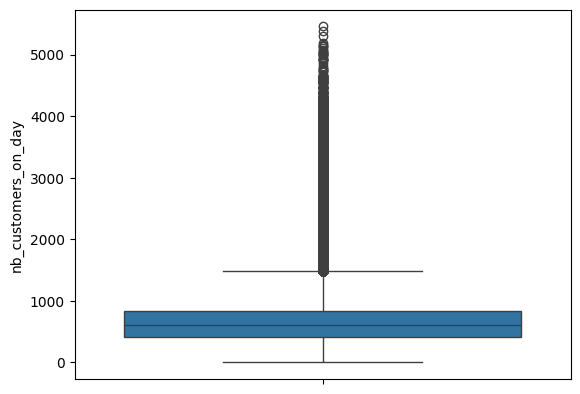

In [23]:
# check outliers
# plt.figure(figsize=(5, 20))
sns.boxplot(data=data, y='nb_customers_on_day')
plt.show()

In [24]:
display(data.shape)
data.drop_duplicates()
display(data.shape)

(640840, 11)

(640840, 11)

In [25]:
data = data[data['nb_customers_on_day'] <= 3000]
data.shape

(638239, 11)

In [26]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
store_ID,638239.0,557.781912,322.028264,1.0,280.0,557.0,837.0,1115.0
day_of_week,638239.0,4.001346,1.996586,1.0,2.0,4.0,6.0,7.0
nb_customers_on_day,638239.0,622.005045,428.634711,0.0,404.0,609.0,834.0,3000.0
open,638239.0,0.829493,0.376078,0.0,1.0,1.0,1.0,1.0
promotion,638239.0,0.381279,0.485701,0.0,0.0,0.0,1.0,1.0
state_holiday,638239.0,0.030744,0.172623,0.0,0.0,0.0,0.0,1.0
school_holiday,638239.0,0.178389,0.382840,0.0,0.0,0.0,0.0,1.0
sales,638239.0,5722.819608,3747.830329,0.0,3720.0,5732.0,7828.0,41551.0
year,638239.0,2013.832356,0.777442,2013.0,2013.0,2014.0,2014.0,2015.0
month,638239.0,5.843963,3.326080,1.0,3.0,6.0,8.0,12.0


> feature selection

In [27]:
correlation = data[['nb_customers_on_day','year','month','day','open']].corrwith(data['sales'])
correlation

nb_customers_on_day    0.901796
year                   0.023706
month                  0.047433
day                   -0.011502
open                   0.692301
dtype: float64

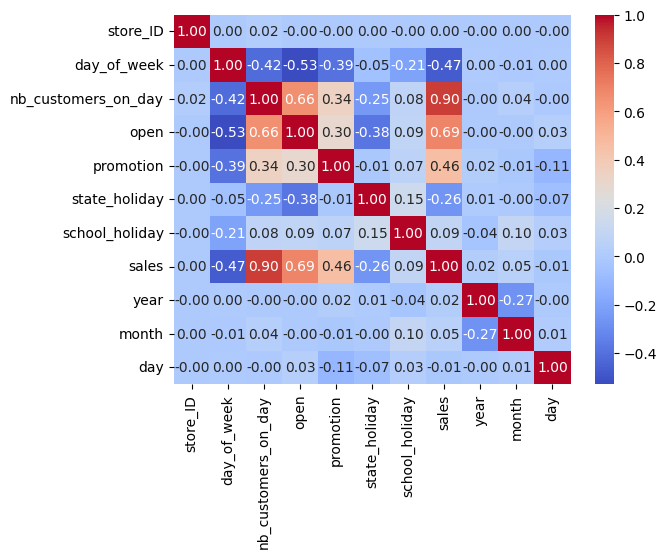

In [28]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [29]:
data.dtypes

store_ID               int64
day_of_week            int64
nb_customers_on_day    int64
open                   int64
promotion              int64
state_holiday          int64
school_holiday         int64
sales                  int64
year                   int32
month                  int32
day                    int32
dtype: object

In [30]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
store_ID,638239.0,557.781912,322.028264,1.0,280.0,557.0,837.0,1115.0
day_of_week,638239.0,4.001346,1.996586,1.0,2.0,4.0,6.0,7.0
nb_customers_on_day,638239.0,622.005045,428.634711,0.0,404.0,609.0,834.0,3000.0
open,638239.0,0.829493,0.376078,0.0,1.0,1.0,1.0,1.0
promotion,638239.0,0.381279,0.485701,0.0,0.0,0.0,1.0,1.0
state_holiday,638239.0,0.030744,0.172623,0.0,0.0,0.0,0.0,1.0
school_holiday,638239.0,0.178389,0.382840,0.0,0.0,0.0,0.0,1.0
sales,638239.0,5722.819608,3747.830329,0.0,3720.0,5732.0,7828.0,41551.0
year,638239.0,2013.832356,0.777442,2013.0,2013.0,2014.0,2014.0,2015.0
month,638239.0,5.843963,3.326080,1.0,3.0,6.0,8.0,12.0


In [31]:
data['part_of_year'] = data['month'].apply(lambda x: 'first' if x <= 7 else 'last')
data.drop(columns='month', inplace=True)
data

/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_26411/3635720239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['part_of_year'] = data['month'].apply(lambda x: 'first' if x <= 7 else 'last')
/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_26411/3635720239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns='month', inplace=True)


,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,year,day,part_of_year
425390,366,4,517,1,0,0,0,4422,2013,18,first
291687,394,6,694,1,0,0,0,8297,2015,11,first
411278,807,4,970,1,1,0,0,9729,2013,29,last
664714,802,2,473,1,1,0,0,6513,2013,28,first
540835,726,4,1068,1,1,0,0,10882,2013,10,last
...,...,...,...,...,...,...,...,...,...,...,...
359783,409,6,483,1,0,0,0,4553,2013,26,last
152315,97,1,987,1,1,0,0,12307,2014,14,first
117952,987,1,925,1,0,0,0,6800,2014,7,first
435829,1084,4,725,1,0,0,0,5344,2014,12,first


In [32]:
X = data.drop(columns='sales')
y = data['sales']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [34]:
categorical_to_encode = ['year', 'part_of_year', 'day', 'day_of_week','open', 'promotion', 'state_holiday', 'school_holiday'] 
numerical_to_scale = ['nb_customers_on_day']

In [35]:
## scale numericals
scaler = MinMaxScaler()
X_train[numerical_to_scale] = scaler.fit_transform(X_train[numerical_to_scale])
X_test[numerical_to_scale] = scaler.transform(X_test[numerical_to_scale])

In [36]:
# ordinal encode categorical
encoder = OrdinalEncoder()
X_train[categorical_to_encode] = encoder.fit_transform(X_train[categorical_to_encode])
X_test[categorical_to_encode] = encoder.transform(X_test[categorical_to_encode])

> build models

In [37]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_preds = linear_model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_preds))
r2 = r2_score(y_test,linear_preds)
display(r2)
display(linear_rmse)

0.8563565090740761

1420.7541662957349

In [38]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, tree_preds))
tree_r2 = r2_score(y_test, tree_preds)
display(tree_r2)
display(tree_rmse)

0.9054107812041601

1152.9136525937658

In [ ]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_preds))
knn_r2 = r2_score(y_test, knn_preds)
display(knn_r2)
display(knn_rmse)

> hyperparamenter tuning

In [ ]:
tree_regressor = DecisionTreeRegressor()
param_grid = {
    'max_depth': [None, 1, 2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['squared_error']
}
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 4}

In [39]:
best_tree_regressor = DecisionTreeRegressor(max_depth=None,
                                            min_samples_split=4,
                                            min_samples_leaf= 4,
                                            criterion='squared_error')
best_tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=4)

In [40]:
tree_preds = tree_model.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, tree_preds))
tree_r2 = r2_score(y_test, tree_preds)
display(tree_r2)
display(tree_rmse)

0.9054107812041601

1152.9136525937658

> Hypothesis Testing

In [ ]:
data.head(1)

In [ ]:
# days of the week <> sales 
# H0 for ANOVA is always that the means of the various groups are the same
# H1 is that they are not the same

In [ ]:
sales_groups = []
for day in range(1,8):
    day_sales = data[data['day_of_week'] == day]['sales'] 
    sales_groups.append(day_sales)
    
print(len(sales_groups))
# sales_groups 

In [ ]:
f_stat, p_val = st.f_oneway(*sales_groups)
print(f_stat)
print(p_val)

In [ ]:
open_groups = []
for status in [0,1]:
    day_sales = data[data['state_holiday'] == status]['sales'] 
    open_groups.append(day_sales)
    
print(len(open_groups))
# sales_groups 

In [ ]:
f_stat, p_val = st.f_oneway(*open_groups)
print(f_stat)
print(p_val)

In [ ]:
open_groups = []
for status in [0,1]:
    day_sales = data[data['school_holiday'] == status]['sales'] 
    open_groups.append(day_sales)
    
print(len(open_groups))
f_stat, p_val = st.f_oneway(*open_groups)
print(f_stat)
print(p_val)
